## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/testing'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training')]

In [5]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/home/ubuntu/.fastai/data/mnist_png/testing/8/4879.png')

In [7]:
defaults.cmap='binary'

In [8]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png

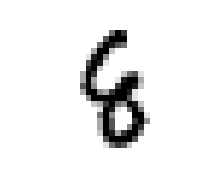

In [9]:
il[0].show()

In [12]:
sd = il.split_by_folder(train='training', valid='testing')

In [13]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [14]:
(path/'training').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/2')]

In [15]:
ll = sd.label_from_folder()

In [16]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: /home/ubuntu/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: /home/ubuntu/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [17]:
x,y = ll.train[0]

8 torch.Size([1, 28, 28])


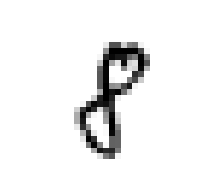

In [18]:
x.show()
print(y,x.shape)

In [19]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [20]:
ll = ll.transform(tfms)

In [21]:
bs = 128

In [22]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [23]:
x,y = data.train_ds[0]

8


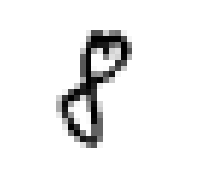

In [24]:
x.show()
print(y)

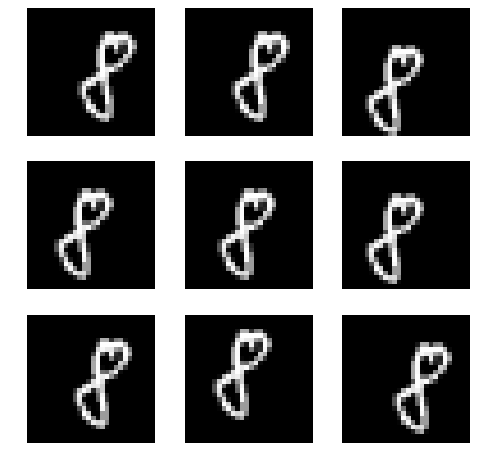

In [25]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [26]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

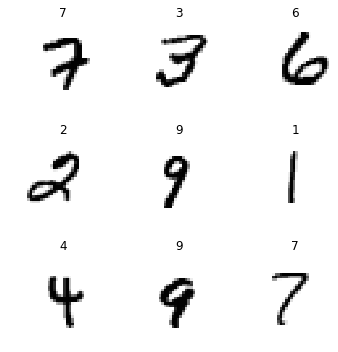

In [27]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [28]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [29]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [30]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [31]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [32]:
xb = xb.cuda()

In [33]:
model(xb).shape

torch.Size([128, 10])

In [34]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


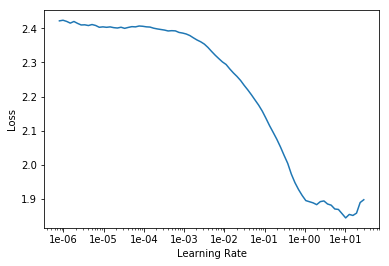

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.223323,0.264478,0.917700
2,0.115579,0.072547,0.977500
3,0.072718,0.040906,0.986900


### Refactor

In [37]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [38]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [39]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [40]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.234354,0.166146,0.948800
2,0.182029,0.200369,0.935800
3,0.164922,0.239948,0.921500
4,0.133524,0.143614,0.955900
5,0.120369,0.104598,0.965800
6,0.092314,0.067111,0.978000
7,0.072991,0.039313,0.987300
8,0.062562,0.032378,0.990200
9,0.045911,0.029238,0.990900
10,0.034320,0.026705,0.991500


### Resnet-ish

In [41]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [42]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **kwargs)
    Resnet block of `nf` features.



In [43]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [44]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [45]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [46]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


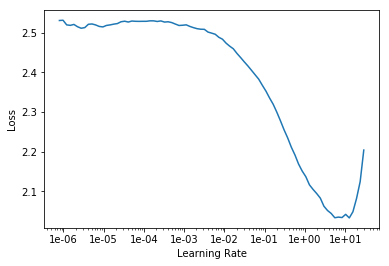

In [47]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.231248,0.144080,0.960900
2,0.134623,0.242324,0.933100
3,0.108668,0.107576,0.967200
4,0.089113,0.101192,0.967100
5,0.068298,0.092464,0.973500
6,0.063843,0.057766,0.983300
7,0.057829,0.047650,0.985000
8,0.045416,0.024507,0.992700
9,0.032287,0.024430,0.992400
10,0.035256,0.023195,0.993100


In [49]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin